<a href="https://colab.research.google.com/github/IrinaProkofieva/AutoML/blob/main/AutoML_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

# **Импорты**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import string
from transformers import pipeline

In [3]:
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Достаем данные**

**Обучающая выборка**

In [32]:
train_data = pd.read_csv('/content/drive/MyDrive/toxic_comments/jigsaw-toxic-comment-train.csv')
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


**Валидационная выборка**

In [5]:
val_data = pd.read_csv('/content/drive/MyDrive/toxic_comments/validation.csv')
val_data

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0
...,...,...,...,...
7995,7995,Il fatto è che la pagina dei personaggi minor...,it,0
7996,7996,El imbesil ete dela luna no se entera ni ostia...,es,1
7997,7997,olum sız manyakmısınz siz adam sıze sanal yıld...,tr,1
7998,7998,El mapa del reinado de Alhaken esta ligerament...,es,0


**Тестовая выборка**

In [6]:
test_data = pd.read_csv('/content/drive/MyDrive/toxic_comments/test.csv')
test_data

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr
...,...,...,...
63807,63807,"No, non risponderò, come preannunciato. Prefer...",it
63808,63808,"Ciao, I tecnici della Wikimedia Foundation sta...",it
63809,63809,innnazitutto ti ringrazio per i ringraziamenti...,it
63810,63810,Kaç olumlu oy gerekiyor? Şu an 7 oldu. Hayır...,tr


Приведем данные к одному виду: добавим колонку с языком в тренировочный датасет, переименуем колонку с текстом в тестовой выборке.

In [35]:
train_data['lang'] = 'en'
test_data = test_data.rename(columns={"content": "comment_text"})

# **Генерация новых признаков**

Была выдвинута теория, что косвенными признаками токсичности текста могут выступать отсутсвие знаков препинания, небольшое или слишком большое количество слов и большая доля заглавных букв.

Для проверки гипотезы добавим новые признаки:
- **words_count** - количество слов в тексте
- **punctuation** - доля знаков препинания в тексте
- **uppercase** - доля заглавных символов в тексте

In [8]:
def enrich_data(data):
  data['words_count'] = data['comment_text'].apply(lambda x: len(x.split()))
  data['punctuation'] = data['comment_text'].apply(lambda x: len(list(filter(lambda c: c in string.punctuation, x))) / len(x))
  data['uppercase'] = data['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x))

In [53]:
enrich_data(train_data)
enrich_data(preprocessed_data)
enrich_data(val_data)
enrich_data(test_data)

# **EDA**

In [10]:
stopwords = stopwords.words(['russian', 'portuguese', 'french', 'italian', 'spanish', 'turkish'])

In [11]:
# Анализ таргета
def show_targed_distribution(data):
  data['toxic'].plot(kind='hist', bins=20, title='toxic')
  toxic_cnt = sum(data['toxic'])
  plt.gca().spines[['top', 'right',]].set_visible(False)

def get_target_distribution(data):
  toxic_cnt = sum(data['toxic'])
  return toxic_cnt, len(data) - toxic_cnt

In [12]:
# Распределение
def show_dist(data, column, show_hist = True, with_target_dist = True):
  hist_data = [data[column]]
  labels = ["All comments"]
  colors = ["#393E46"]
  if with_target_dist:
    toxic_nums = data.query("toxic == 1")[column]
    non_toxic_nums = data.query("toxic == 0")[column]
    hist_data = hist_data + [toxic_nums, non_toxic_nums]
    labels = labels + ["Toxic comments", "Non toxic comments"]
    colors = colors + ["#2BCDC1", "#F66095"]
  fig = ff.create_distplot(
      hist_data=hist_data,
      group_labels=labels,
      show_hist=False,
      colors = colors
  )

  fig.update_layout(title_text=column, xaxis_title=column, template="simple_white", showlegend=True)
  fig.show()

In [13]:
# Анализ языков
def count_language(data):
  data.groupby('lang').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
  plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
# Самые частотные слова
def visualize_most_frequent_words(data, is_toxic):
  subset = data.query(f"toxic == {int(is_toxic)}")
  label = "Toxic" if is_toxic else "Non toxic"
  visualize_most_frequent_words_inner(subset, label)

def visualize_most_frequent_words_all(data):
  visualize_most_frequent_words_inner(data, "All")

def visualize_most_frequent_words_inner(data, label):
  text = data.comment_text.values
  wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords)
  wc.generate(" ".join(text))
  plt.figure(figsize=(7.5, 7.5))
  plt.axis("off")
  plt.title(f"Words frequented in {label} Comments", fontsize=16)
  plt.imshow(wc.recolor(colormap = 'viridis', random_state=17), alpha=0.98)
  plt.show()

In [69]:
def show_correlation(data):
    correlation_matrix = data[['toxic', 'uppercase', 'punctuation', 'words_count']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation matrix')
    plt.show()

## **Обучающая выборка**

**Анализ таргета**

Number of non toxic comment: 202165
Number of toxic comment: 21384


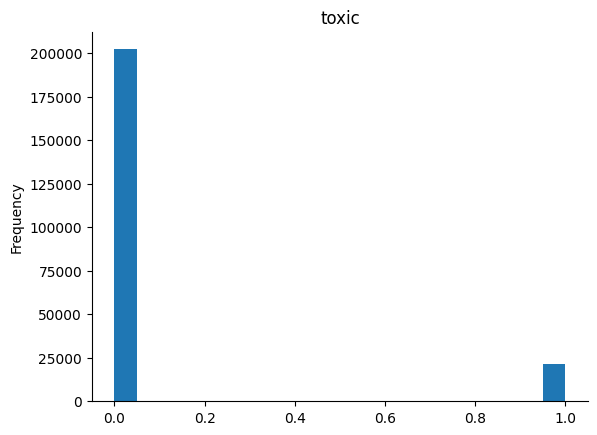

In [33]:
toxic, nontoxic = get_target_distribution(train_data)
print(f"Number of non toxic comment: {nontoxic}")
print(f"Number of toxic comment: {toxic}")
show_targed_distribution(train_data)

**Знаки препинания**

Можно заметить, что в большинстве случаев доля знаков пунктуации составляет не более 0.1. Однако для токсичных комментариев действительно более характерны случаи полного их отсутствия.

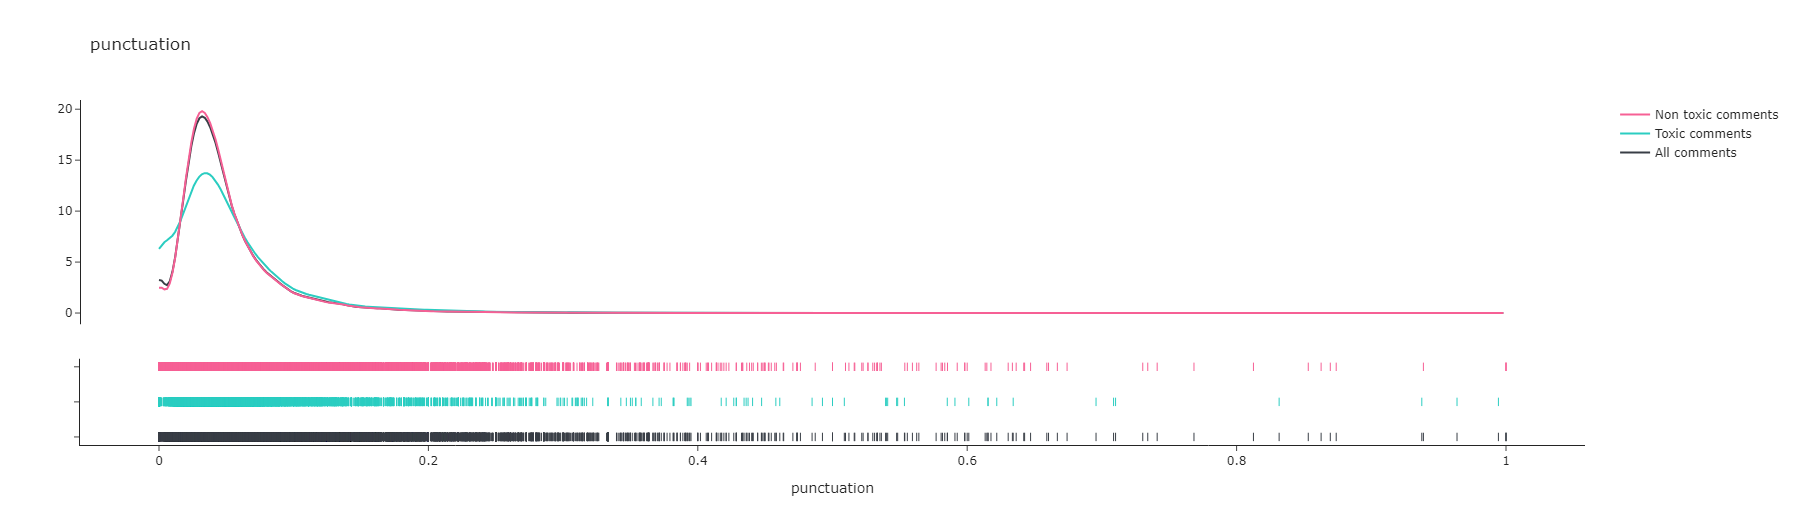

In [38]:
show_dist(train_data.sample(frac=0.5), 'punctuation', False)

Кроме того, можно заметить, что есть комментарии, в которых доля знаков препинания близка к 1. Скорее всего, такие значения можно считать аномальными. Посмотрим на эти значения

In [57]:
train_data[train_data['punctuation']>0.85]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang,words_count,punctuation,uppercase
43282,73896b84dd23bee3,i apologize for my attack .......................,0,0,1,0,1,0,en,9,0.876877,0.000000
48878,82af3b426e8bad90,"Wikipedia, I have one itty bitty question. LEA...",0,0,0,0,0,0,en,20,0.889753,0.067845
52727,8cee04ab6861a675,I'M GONNA KILL YOU!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,1,1,0,1,0,0,en,100,0.909237,0.070437
75499,c9f42b4dedc3cbf0,YOU!\nYou blocked me worm why!!!!!!!!!!!!!!!!!...,1,0,0,0,0,0,en,7,0.994366,0.000805
135857,d6ab1b62b0d08a2e,why don't you suck my ass until your lips blee...,1,1,1,0,1,0,en,30,0.969813,0.016100
136145,d83da9b75405f190,hi trextori12 ) I♥♥♥u girl!!!!!!!!!!!!!!!!!!!!...,0,0,0,0,0,0,en,5,0.920382,0.003185
139496,eaac752ae552d44a,'''[[\n== [[\n[[== THIS SITE IS STUPID DON'T T...,1,0,0,0,1,0,en,13,0.970183,0.020642
154343,aca4e239043dddad,"""\n.\n Happy Valentine's Day ...................",0,0,0,0,0,0,en,7,0.862745,0.014706
161892,096392c36124b1ca,== LIES == \n\n THESE PEOPLE ARE LYING LIARS. ...,0,0,0,0,0,0,en,18,0.968237,0.023911
163920,11a2df75a9d47b14,wikipeda.org is awsome so awsome!!!!!!!!!!!!!!...,0,0,0,0,0,0,en,5,0.853211,0.000000


**Доля заглавных букв**

Посмотрим на распределение доли заглавных букв. Можно заметить, что для большинства текстов доля заглавных букв составляет не более 0.1. Однако для токсичных комментариев пик более сглажен, чем для нейтральных. Также стоит отметить, что для токсичных комментариев наблюдается небольшой всплеск в районе значения 0.8. В датасете присутствуют комментарии полностью состоящие из заглавныъ букв, но едва ли эти значения можно считать аномальными.

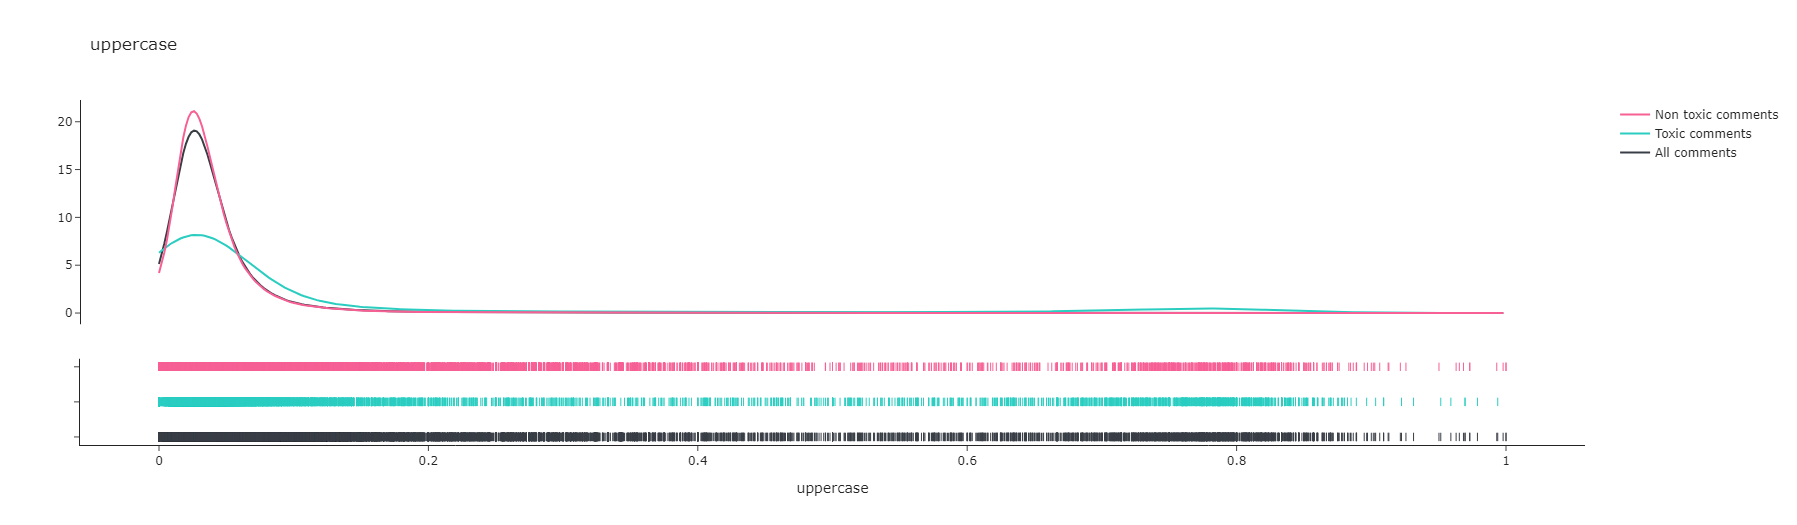

In [39]:
show_dist(train_data.sample(frac=0.5), 'uppercase', False)

**Количество слов в тексте**

Пик немного смещен вправо для токсичных комментариев, но в целом значения распределены достаточно равномерно.

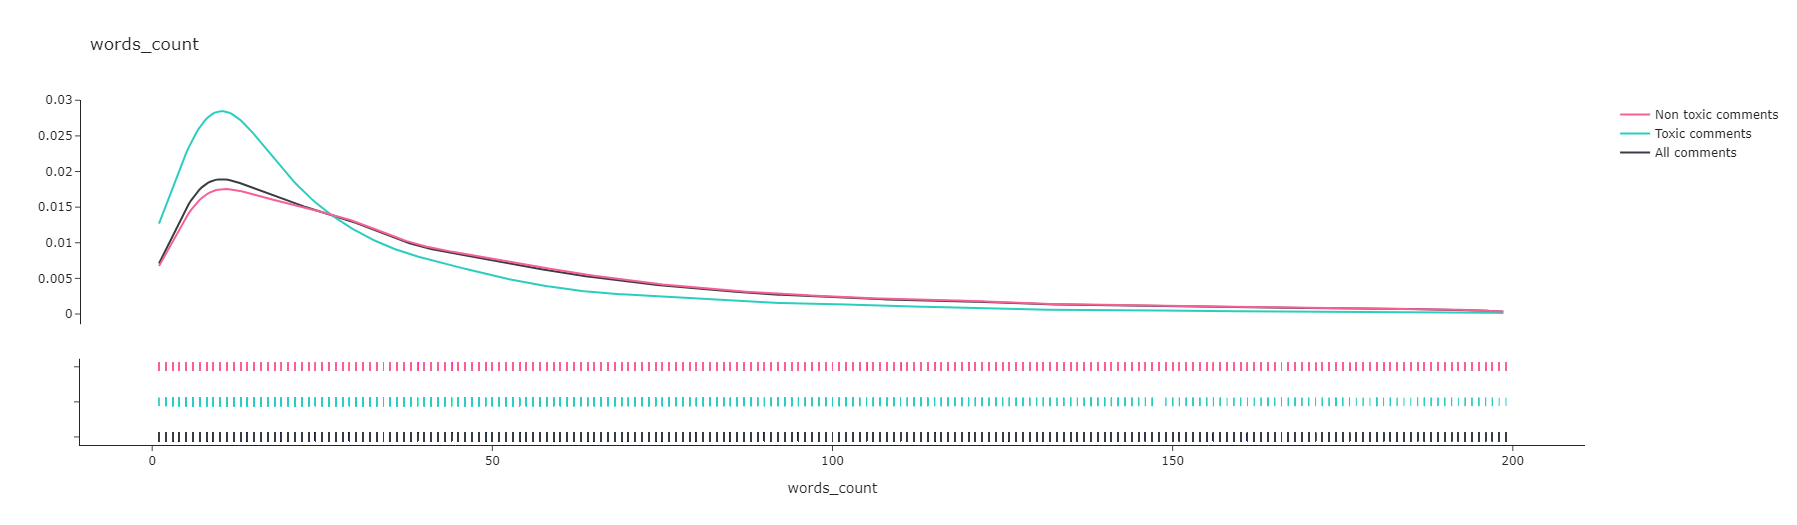

In [40]:
show_dist(train_data[train_data['words_count'] < 200].sample(frac=0.5), 'words_count')

Посмотрим на текст с максимальным количеством слов.

In [66]:
max_words_count = max(train_data['words_count'])
print(max_words_count)
train_data[train_data['words_count'] == max_words_count]

2321


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang,words_count,punctuation,uppercase
201191,a60d51188aad42f0,C O M M I E - F U C K E R C O M M I E - F U C ...,1,0,1,0,1,0,en,2321,0.038569,0.461538


Минимальное количество слов.

Видно, что пустых текстов (пропущенных значений) нет.

In [93]:
min(train_data['words_count'])

1

**Языки**

Для обучающей выборки все данные представлены на английском языке.

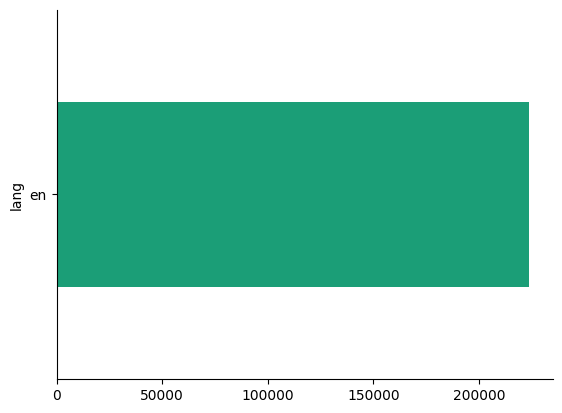

In [36]:
count_language(train_data)

Можно посмотреть на самые частотные слова в зависимости от таргета.

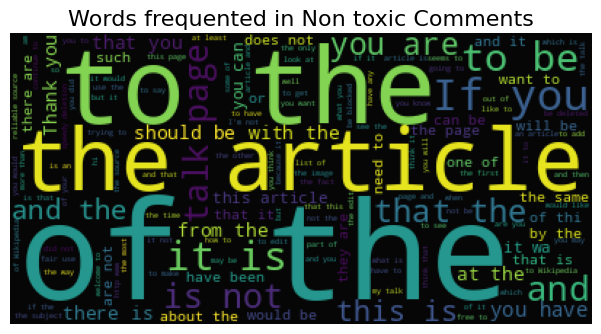

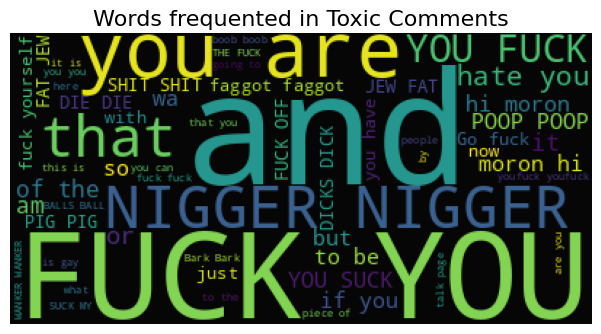

In [37]:
visualize_most_frequent_words(train_data, False)
visualize_most_frequent_words(train_data, True)

**Матрица корреляции**

В целом, видно, что с таргетом у punctuation и words_count корреляция практически нулевая, а для uppercase наблюдается слабая прямая корреляция с таргетом.

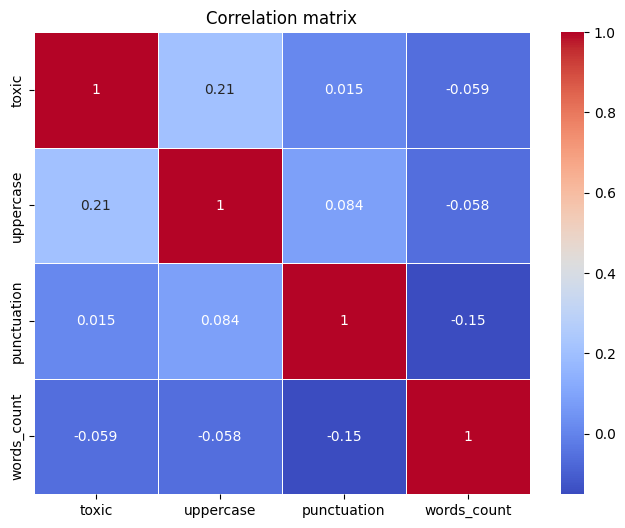

In [59]:
show_correlation(train_data)

## **Валидационная выборка**

**Анализ таргета**

Number of non toxic comment: 6770
Number of toxic comment: 1230


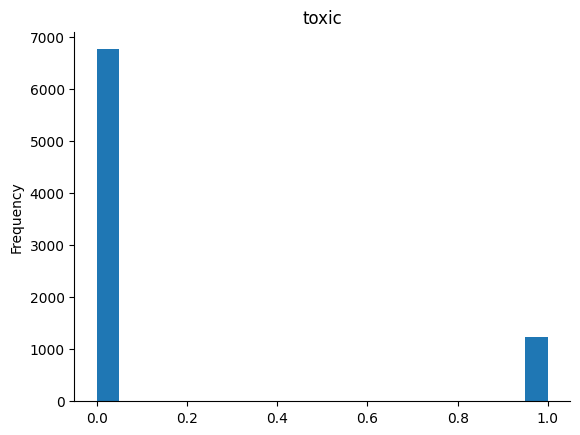

In [21]:
toxic, nontoxic = get_target_distribution(val_data)
print(f"Number of non toxic comment: {nontoxic}")
print(f"Number of toxic comment: {toxic}")
show_targed_distribution(val_data)

**Знаки препинания**

Ситуация схожа с обучающей выборкой, но в валидационном датасете нет значений, для которых доля пунктуации превышает 0.5.

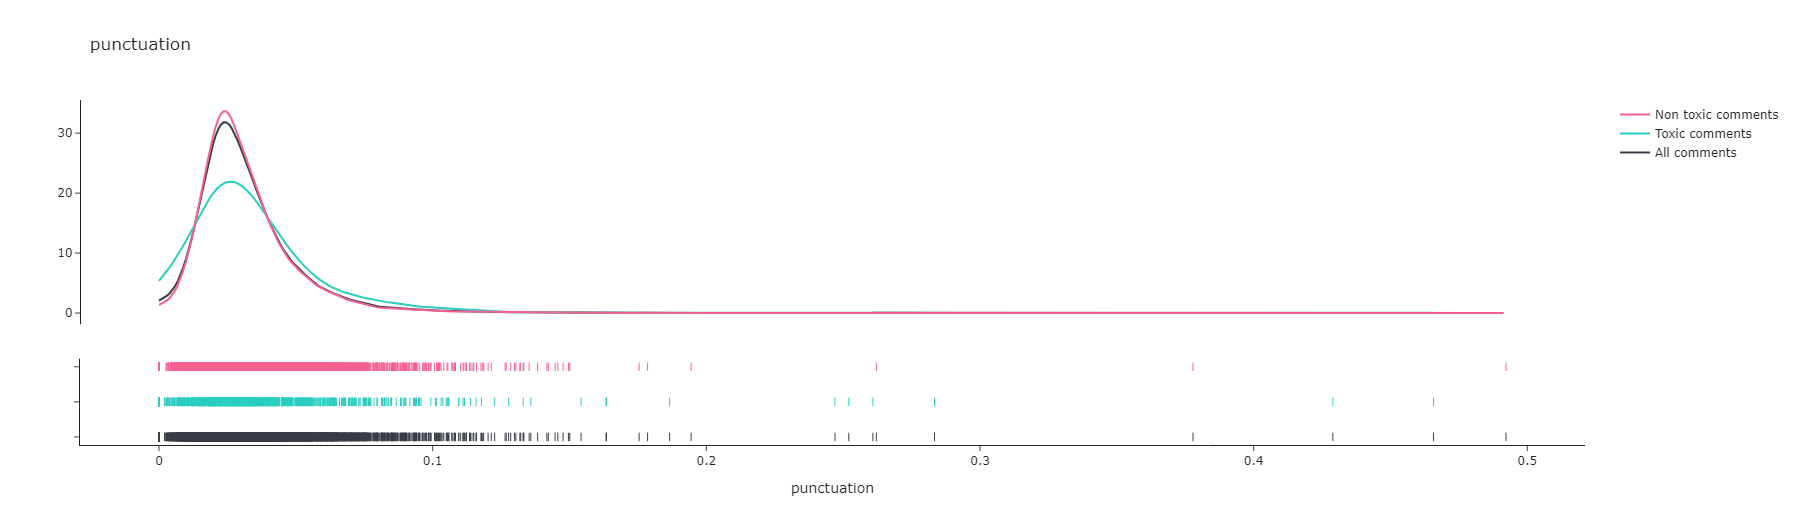

In [44]:
show_dist(val_data, 'punctuation')

**Доля заглавных букв**

График очень похож на график распределения для обучающей выборки, включая некоторый всплеск на значении 0.8.

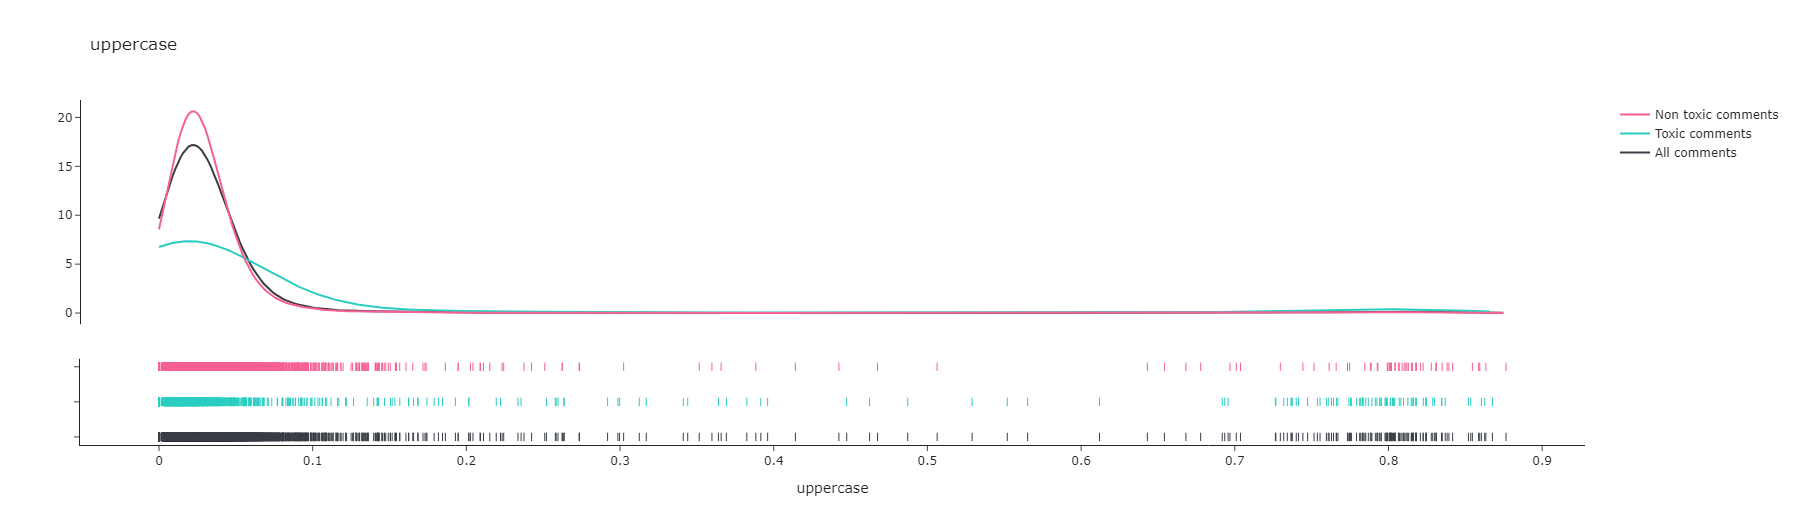

In [45]:
show_dist(val_data, 'uppercase')

**Количество слов**

График похож на обучающую выборку. Максимальное количество слов в тексте чуть больше 200.

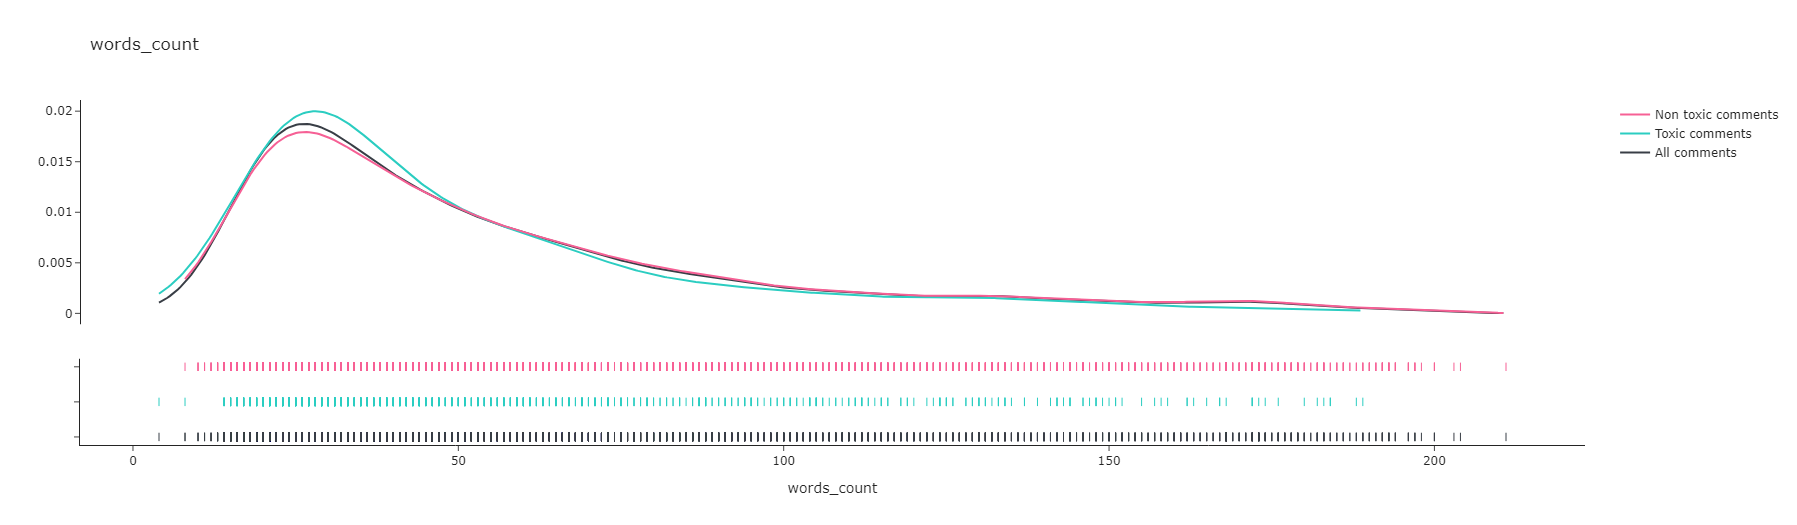

In [46]:
show_dist(val_data, 'words_count')

Минимальное количество слов.

Видно, что пропущенных значений нет.

In [94]:
min(val_data['words_count'])

4

**Языки**

В валидационной выборке, в отличие от обучающей, присутствуют слова на турецком, итальянском и испанском языках.

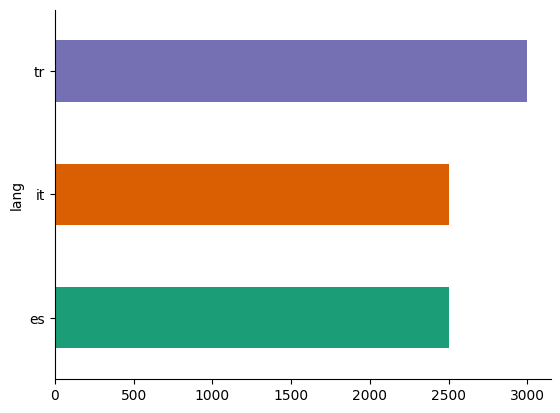

In [25]:
count_language(val_data)

Самые частотные слова

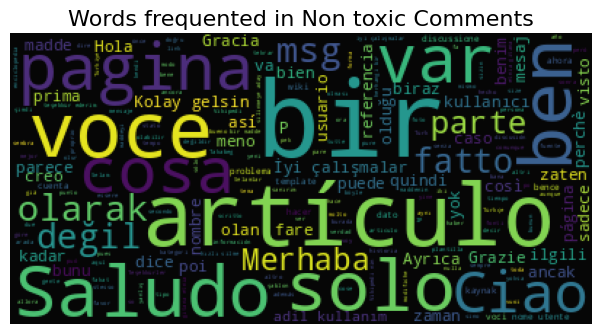

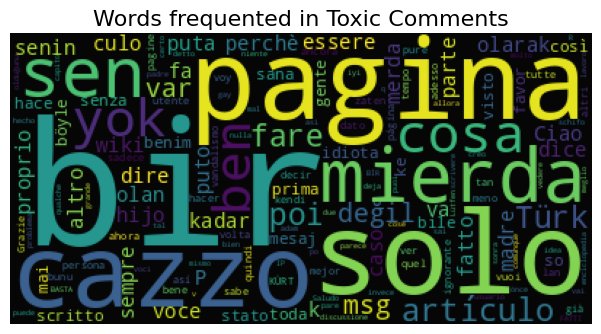

In [26]:
visualize_most_frequent_words(val_data, False)
visualize_most_frequent_words(val_data, True)

**Матрица корреляции**

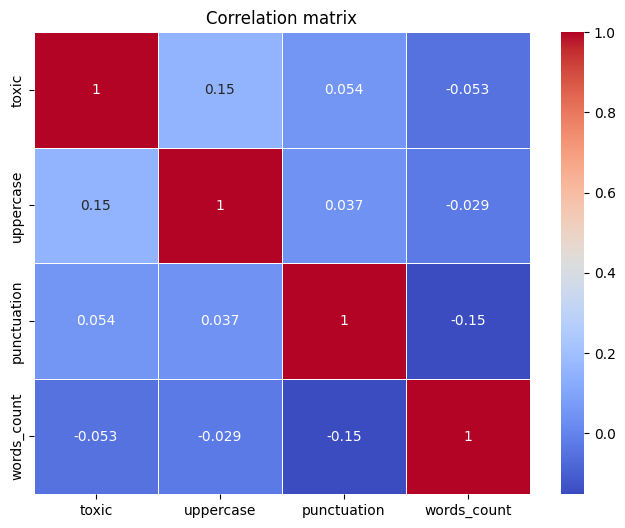

In [75]:
show_correlation(val_data)

## **Тестовые данные**

Посмотрим на данные, которые нам даны в качестве тестовых.

**Знаки препинания**

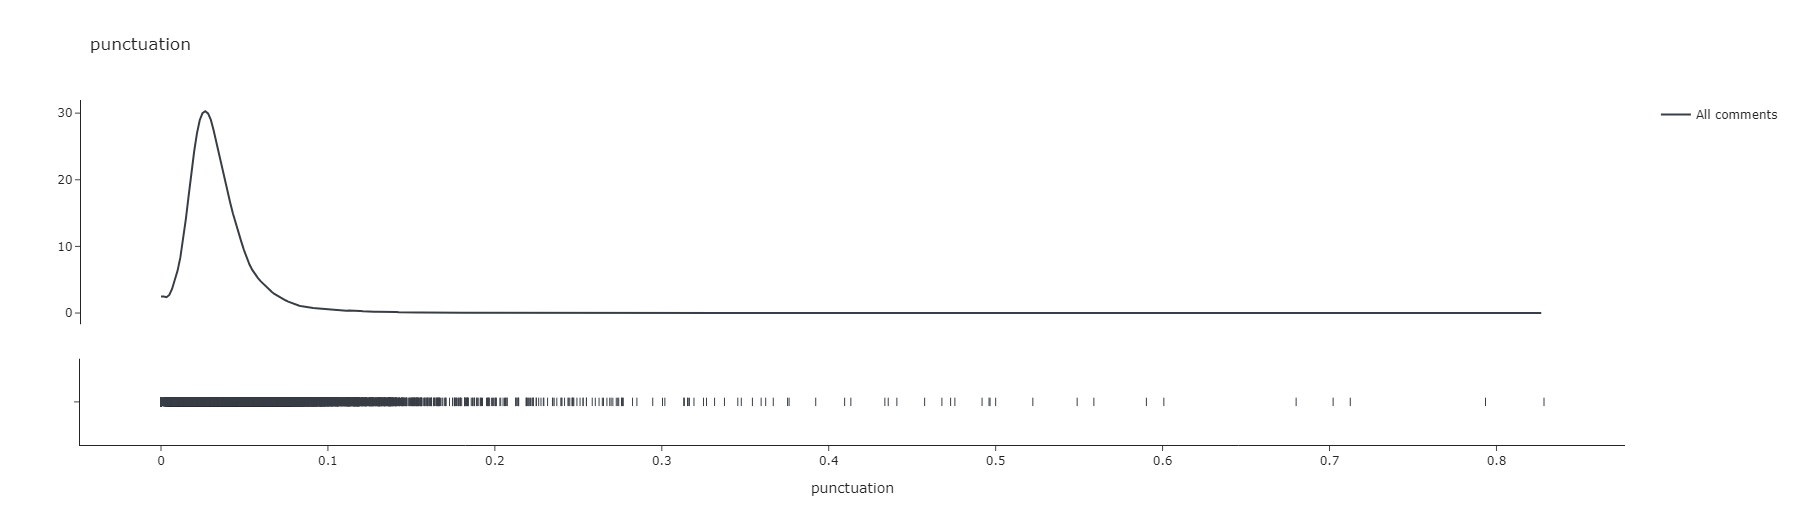

In [76]:
show_dist(test_data, 'punctuation', False, False)

**Заглавные буквы**

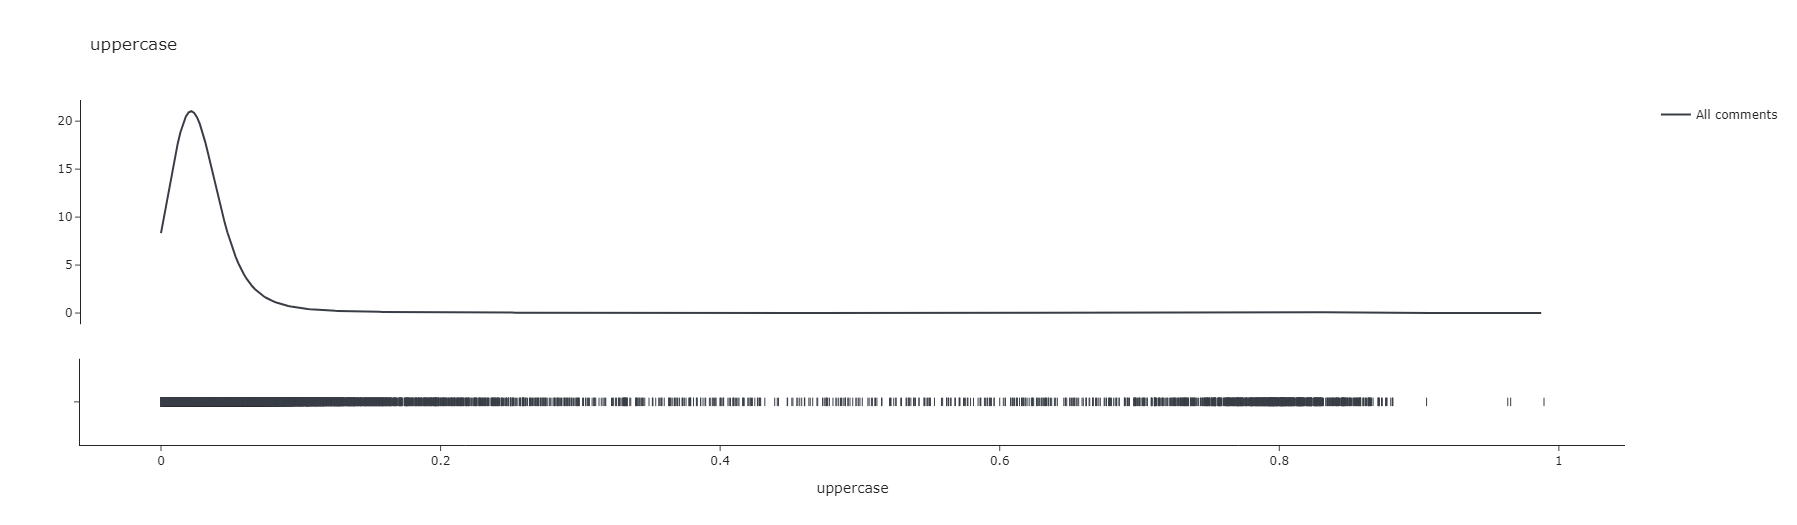

In [77]:
show_dist(test_data, 'uppercase', False, False)

**Количество слов**

Так же, как и в валидационной выборке, максимальное количество слов немного больше 200.

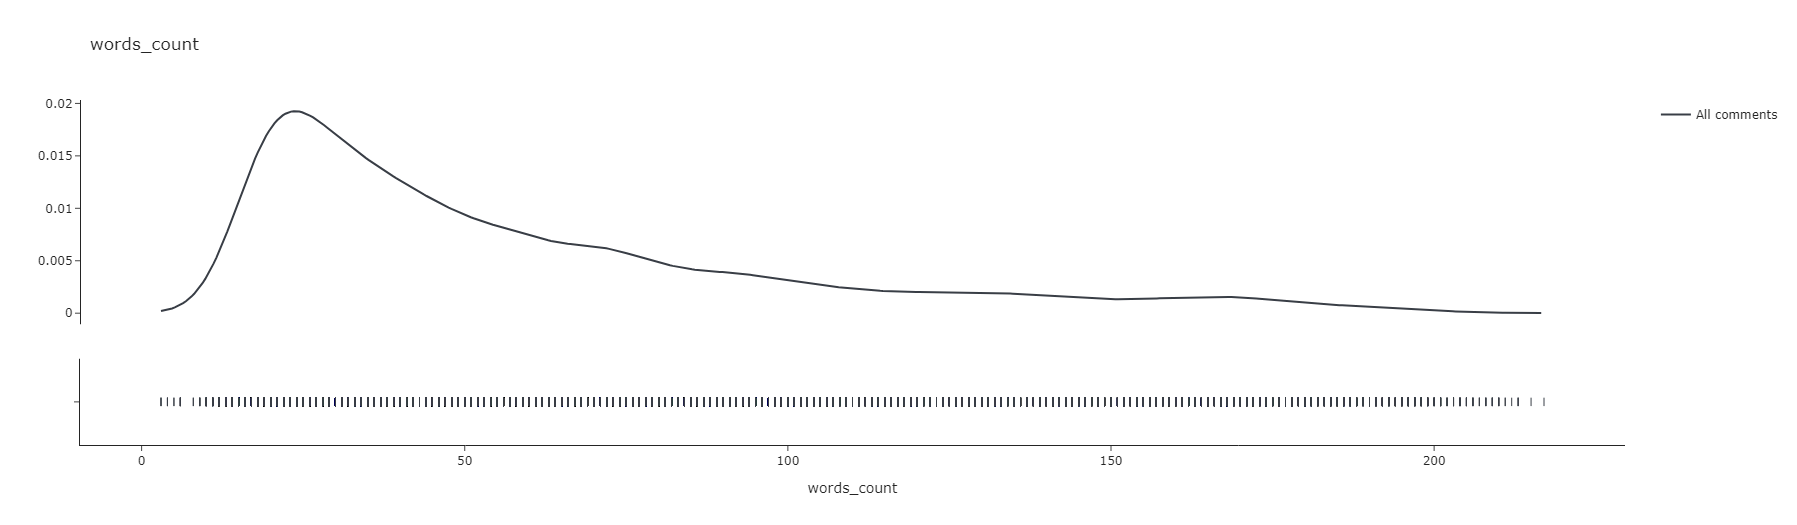

In [78]:
show_dist(test_data, 'words_count', False, False)

Минимальное количество слов.

Видно, что пропущенных значений нет.

In [95]:
min(test_data['words_count'])

3

**Языки**

В тестовой выборке данные представлены на 6 языках. Кроме упомянутых в валидационной выборке, появились русский, португальский и французский языки.

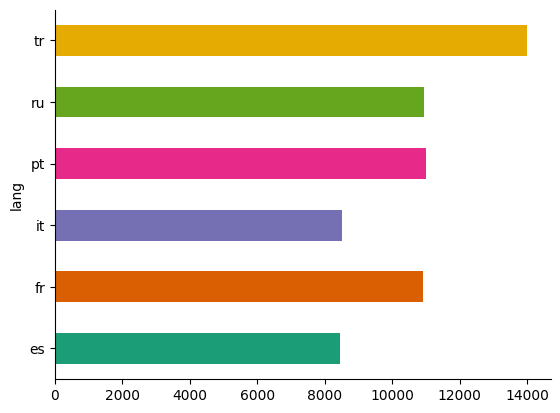

In [79]:
count_language(test_data)

Наиболее частотные слова

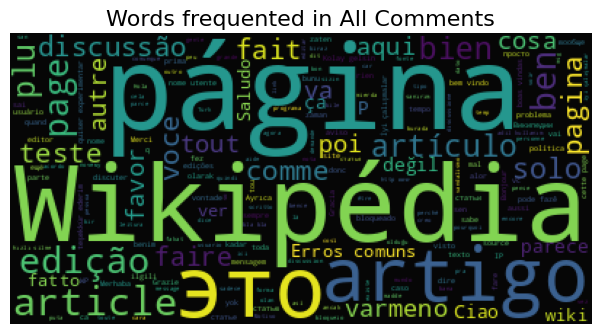

In [80]:
visualize_most_frequent_words_all(test_data)

# **Подготовка обучающих данных**

## **Предобработка данных**

Как видно, обучающий датасет состоит из английских комментариев, в то время как тестовый датасет содержит тексты на других языках. Мною была выдвинута гипотеза, что небольшой обучающий датасет на разных языках может быть эффективнее большого на другом языке. Для проверки этой гипотезы был составлен новый обучающий датасет. В качестве препроцессинга данные из обучающего датасета были переведены на языки, встречающиеся в тестовой выборке. В силу ограниченности ресурсов предобработана была только часть данных, выбранных случайным образом с попыткой сбалансировать неравномерность распределения таргета в обучающей выборке.

In [ ]:
pipe_translation = pipeline("translation", model="facebook/mbart-large-50-many-to-many-mmt", device=device)

In [ ]:
languages = {
    'ru': 'ru_RU',
    'it': 'it_IT',
    'pt': 'pt_XX',
    'es': 'es_XX',
    'tr': 'tr_TR',
    'fr': 'fr_X'
}

In [ ]:
def translate_text(t, dest_lang):
  try:
    return pipe_translation(t, src_lang="en_EN", tgt_lang=dest_lang)[0]['translation_text']
  except Exception as e:
    return None

In [ ]:
def preprocess_dataset(data):
  new_dataset = pd.DataFrame()
  for lang, code in languages:
    for i in range(2):
      translated_data = data[(data['toxic']==1) & (data['comment_text'].str.split().apply(lambda x: len(x))<40)].sample(200)
      translated_data['comment_text'] = data['comment_text'].apply(lambda x: translate_text(x, code))
      translated_data = translated_data[translated_data['comment_text'].notnull()]
      new_dataset = pd.concat([new_dataset, translated_data])
  return new_dataset

In [ ]:
preprocessed_data = preprocess_dataset(train_data)
preprocessed_data.to_csv('/content/drive/MyDrive/toxic_comments/preprocessed_train_data.csv')

## **Обучающая выборка после предобработки. Визуализация**

In [4]:
preprocessed_data = pd.read_csv('/content/drive/MyDrive/toxic_comments/preprocessed_train_data.csv')
preprocessed_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang
0,0002bcb3da6cb337,CABEZA ANTES DE QUE PESES EN MI TRABAJO,1,1,1,0,1,0,es
1,0005c987bdfc9d4b,Oye... ¿qué es lo que... @ hablar. ¿Qué es......,1,0,0,0,0,0,es
2,0007e25b2121310b,"¡No mires, ven o piensa en volver!",1,0,0,0,0,0,es
3,001810bf8c45bf5f,¿Eres gay o antisemita? ¡Arcángel WHIte Tiger ...,1,0,1,0,1,1,es
4,00190820581d90ce,"¡A la mierda con tu madre en el culo, seca!",1,0,1,0,1,0,es
...,...,...,...,...,...,...,...,...,...
1846,0686e75d206dbd61,"""Bu söz konusu olmaz. Bir haftadan uzun süredi...",0,0,0,0,0,0,tr
1847,0687f3591d0cb043,3 tür geothermal enerjinin 3 türünün ne olduğu...,0,0,0,0,0,0,tr
1848,06889bcb5e18bb47,"Mary Walker ""Mary Walker"" Bilmek zorundayım......",0,0,0,0,0,0,tr
1849,0688fb9174122530,Wikipedia Administrators Attention Wikipedia A...,0,0,0,0,0,0,tr


**Анализ таргета**

Number of non toxic comment: 1257
Number of toxic comment: 594


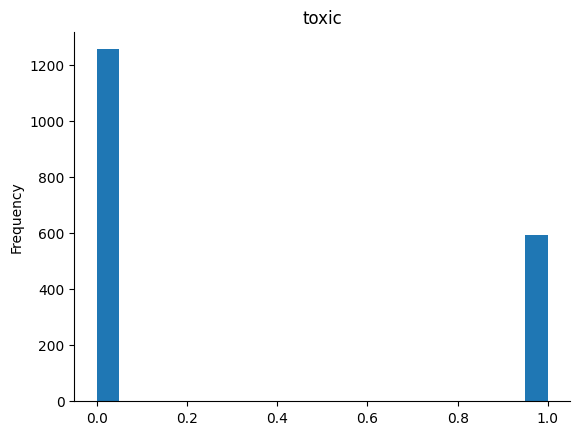

In [15]:
toxic, nontoxic = get_target_distribution(preprocessed_data)
print(f"Number of non toxic comment: {nontoxic}")
print(f"Number of toxic comment: {toxic}")
show_targed_distribution(preprocessed_data)

**Знаки препинания**

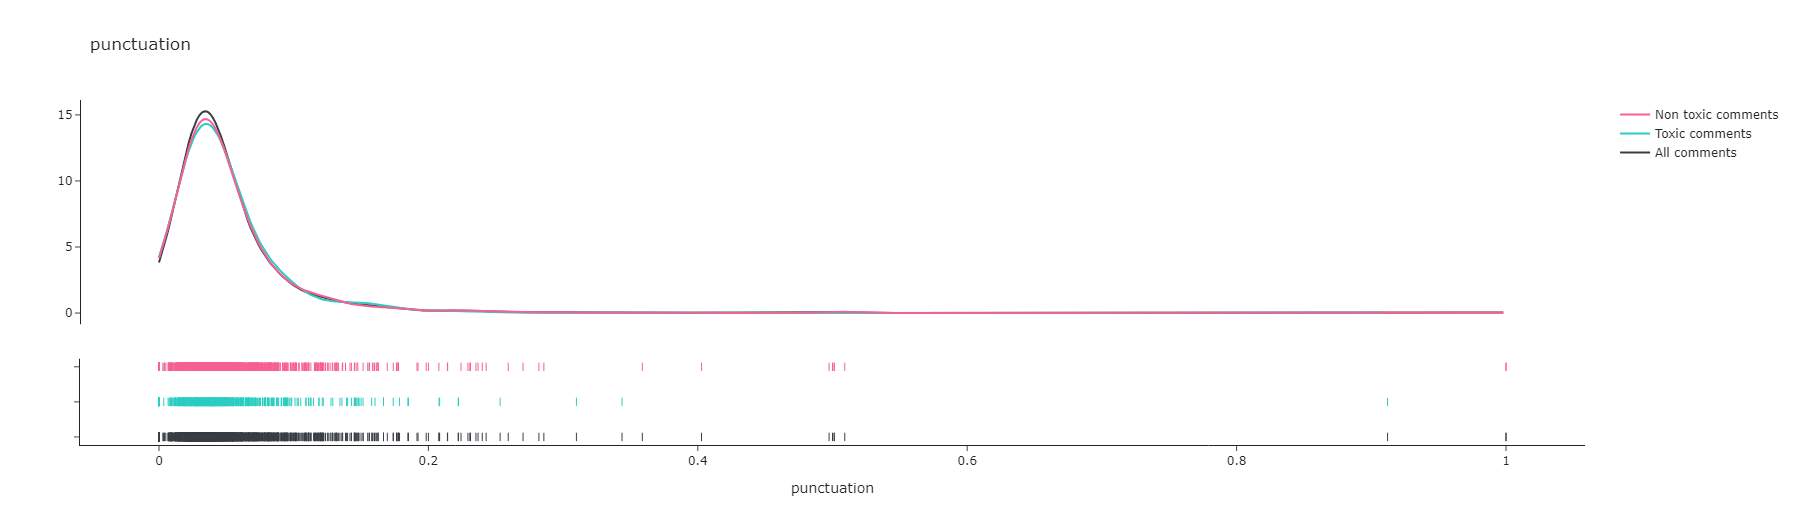

In [41]:
show_dist(preprocessed_data, 'punctuation')

**Заглавные буквы**

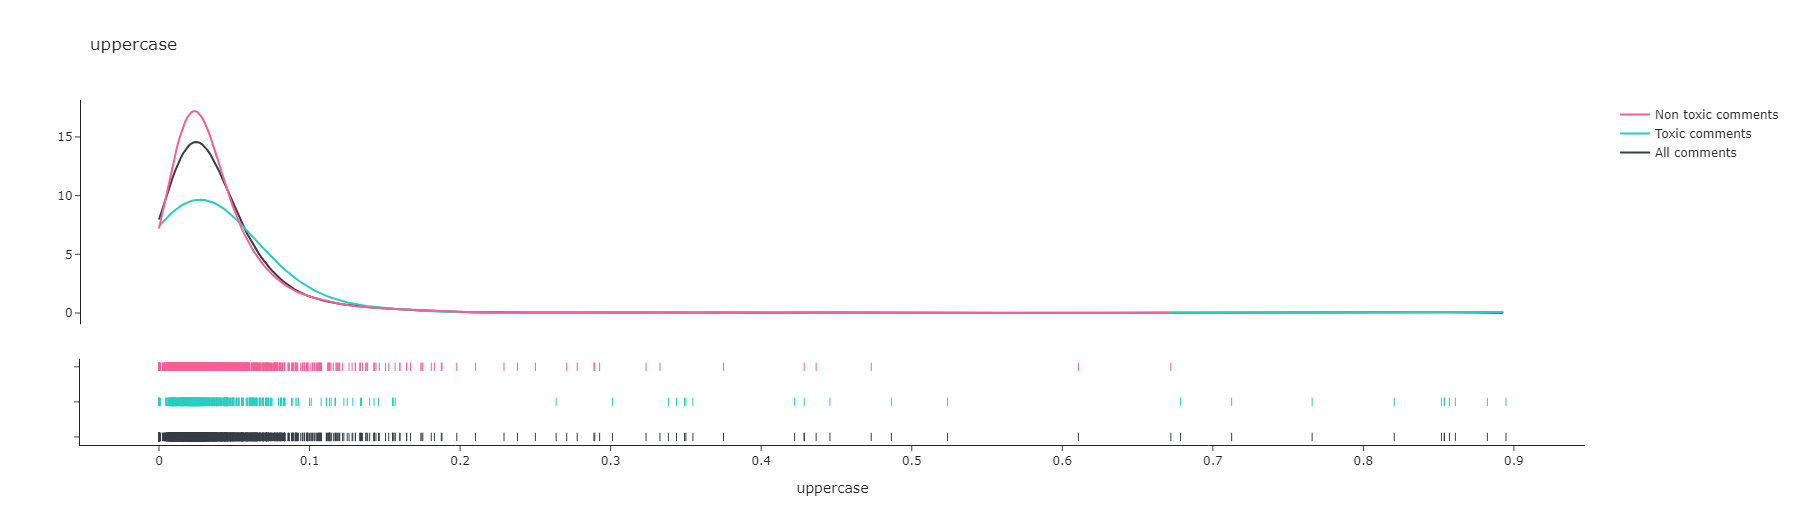

In [42]:
show_dist(preprocessed_data, 'uppercase')

**Количество слов**

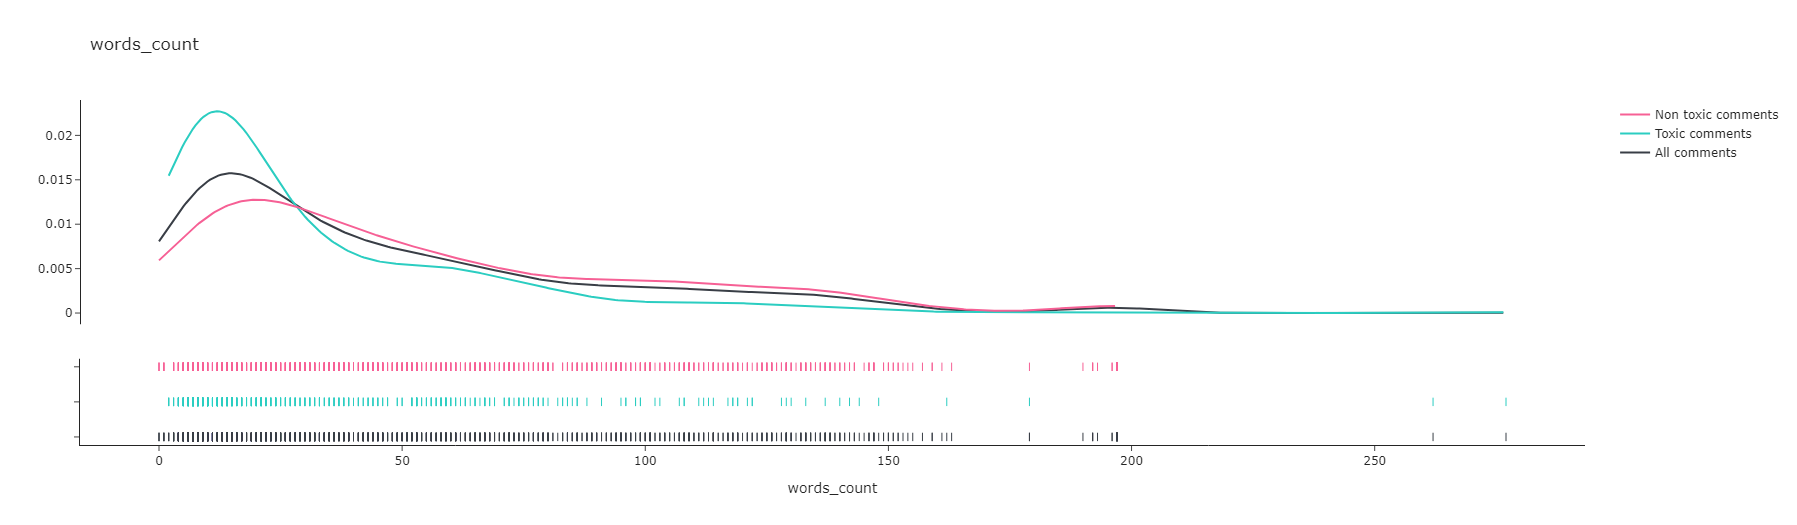

In [43]:
show_dist(preprocessed_data, 'words_count')

**Языки**

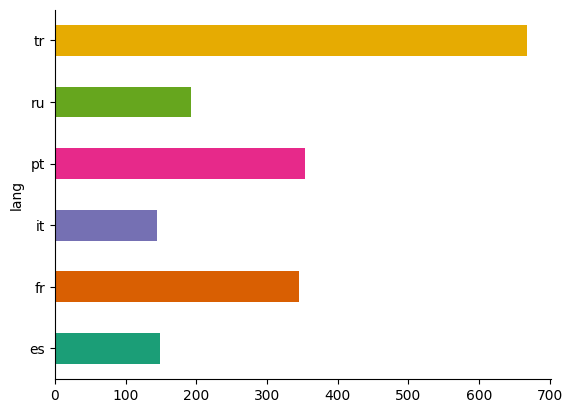

In [19]:
count_language(preprocessed_data)

Самые частотные слова

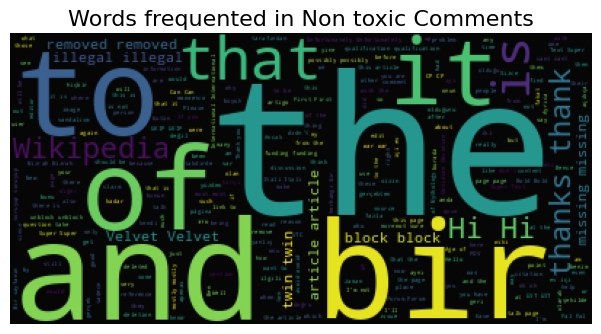

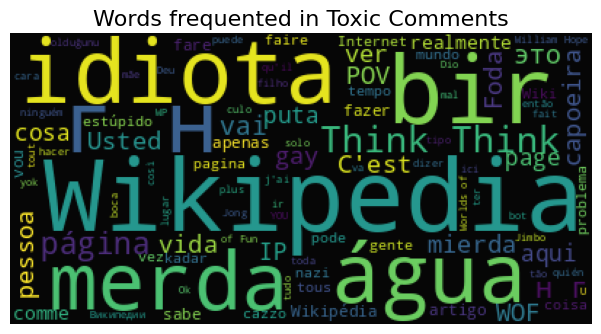

In [20]:
visualize_most_frequent_words(preprocessed_data, False)
visualize_most_frequent_words(preprocessed_data, True)

**Матрица корреляции**

В получившемся датасете потерялась корреляция между uppercase и таргетом.

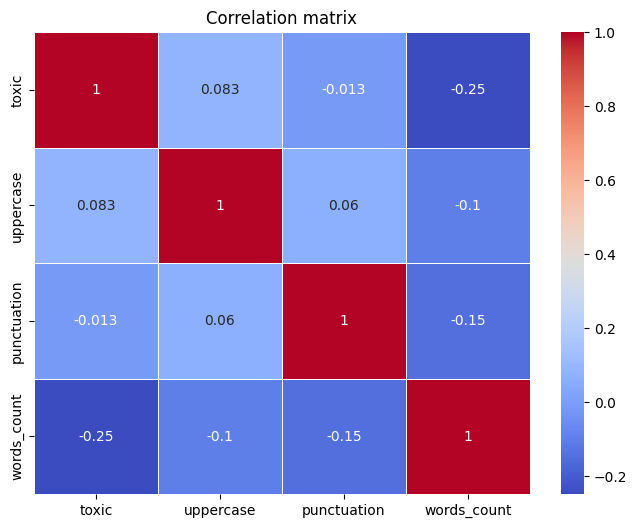

In [81]:
show_correlation(preprocessed_data)

## **Выводы**

- Нет сильных корреляций между добавленными признаками и таргетом, из добавленных признаков наиболее полезным кажется uppercase, однако новые признаки могут помочь в поиске аномальных значений
- Распределения для новых признаков сохраняются вне зависимости от языка
- Аномальными значениями можно считать тексты, количество слов в которых превышает 250 или доля пунктуации в которых больше 0.5
- Для очистки обучающего датасета стоит отфильтровать тексты с количеством слов > 250 и тексты, доля пунктуации в которых больше 0.5
- Пропущенных значений в датасете нет
- Распределение на обучающую и валидационную выборку валидно, поскольку пересекающихся значений нет

In [90]:
# Функция для очистки датасета
def clear_dataset(data):
  return data[(data['punctuation'] < 0.5) & (data['words_count'] < 250)]

In [91]:
clear_dataset(train_data)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang,words_count,punctuation,uppercase
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,en,43,0.037879,0.064394
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,en,17,0.107143,0.071429
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,en,42,0.025751,0.017167
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,en,113,0.033762,0.017685
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,en,13,0.074627,0.029851
...,...,...,...,...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0,en,106,0.028523,0.018456
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0,en,13,0.110497,0.060773
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0,en,14,0.121951,0.012195
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0,en,27,0.014599,0.795620
